# F1 Racing Simulator

Simulating F1 racing with various control variables such as budgets, drivers and weather.\

Weather will increase the randomness of driver failing to finish the race because they crashed.\

Todo: \
non-determinism\
drivers\
weather

In [1]:
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from teams import Team

In [2]:
# Team budget: https://beyondtheflag.com/2019/11/06/formula-1-current-team-budgets-175m-cap-impending/
F1_teams = {
    'mercedes': Team("Mercedes", 484),
    'redbull': Team("Red Bull", 445),
    'ferrari': Team("Ferrari", 463),
    'mclaren': Team("McLaren", 269),
    'renault': Team("Renault", 272),
    'racingpoint': Team("Racing Point", 188),
    'haas': Team("Haas", 173),
    'alfaromeo': Team("Alfa Romeo Racing", 141),
    'tororosso': Team("Toro Rosso", 138),
    'williams': Team("Williams", 132)
}

genesis_states = {'Race_teams': F1_teams}

Policy function will determine how many points each team earns.\
For now, fastest car will always win the race.

In [3]:
point_scale = [25, 18, 15, 12, 10, 8, 6, 4, 2, 1]  

# Policy functions
def p_update_rank(_params, substep, sH, s, **kwargs):

    prev_state = s['Race_teams']
    
    # For now, the team with a fastest car will win
    sorted_state = sorted(F1_teams.items(), key=lambda team:team[1].car_speed(), reverse=True)
    
    # Generate points to add
    
    add_to_team: Dict[str, int] = {}
        
    for i in range(0, 10):
        add_to_team.update({sorted_state[i][0]: point_scale[i]})
        
    return add_to_team

In [4]:
# State update function
def s_team(_params, substep, sH, s, _input, **kwargs):
    
    prev_state = s['Race_teams']
    
    new_state = {}
    
    for key, value in prev_state.items():
        points = value.get_points()
        
        total = points + _input[key]
        
        new_state[key] = Team(value.get_name(), value.get_budget())
        
        new_state[key].add_points(total)
        
    return ('Race_teams', new_state)
    

In [5]:
# Partial update blocks
PUB = [{
    "policies":
    {
        "action": p_update_rank
    },
    "variables":
    {
        'Race_teams': s_team
    }
}]

In [6]:
sim_params = {
    'N': 1,
    'T': range(5),
    'M': {}
}

In [7]:
exp = Experiment()
exp.append_model(
    initial_state = genesis_states, 
    partial_state_update_blocks = PUB, 
    sim_configs=sim_params)

config = exp.configs

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

exec_mode = ExecutionMode()
local_proc_ctx = ExecutionContext(context=exec_mode.local_mode)

run = Executor(exec_context=local_proc_ctx, configs=config)

raw_result, tensor_fields, _ = run.execute()
result = pd.DataFrame(raw_result)

print(tabulate(result, headers='keys', tablefmt='psql'))


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 5, 0, 1, 1)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (5, 0, 1, 1)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.00s
+----+---------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+----------+-------+-----------+------------+
|    | Race_teams                                                                                                                                                    |   simulation |   subset |   run |   substep |   timestep |
|----+--

<AxesSubplot:xlabel='timestep'>

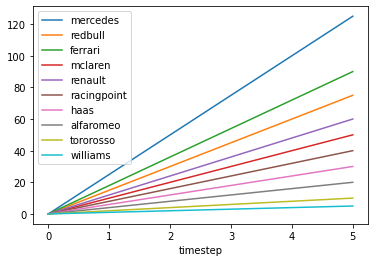

In [55]:
new_result = []
for i in raw_result:
    row = {}
    for key, value in i.items():
        if key == 'Race_teams':
            for key, value in value.items():
                row.update({key: value.get_points()})
        elif key == 'timestep':
            row.update({key: value})
    new_result.append(row)

pd.DataFrame(new_result).plot('timestep')